## Comments

1. LED_state should change to "LED_Position", and its value should change to 'R' and 'L'. we dont have to look every time, to make sure.
2. Change the get_latency method so it doesnt take dataframes as input

**The Photodiodes must be covered for "Total" experiment. We might as well jus design a cover for the shield as we talked about earlier**

In [138]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

import vrlatency as vrl

%matplotlib tk

In [2]:
path_data = '../../data/Projector/'
path_fig = ''

In [3]:
os.chdir(path_data)

In [4]:
filenames = []
for ind, filename in enumerate(glob.glob('*.csv')):
    filenames.append(filename)
    print(filename)

display_20180920_041400.csv
total_20180920_043219.csv
tracking_20180920_035215.csv


In [5]:
filename = filenames[1]
session = filename.split('.')[0]
session

'total_20180920_043219'

In [125]:
dfd = vrl.read_csv(filename)
dfd.head()

,Trial,Time,LeftSensorBrightness,RightSensorBrightness,LED_State
0,2,96,9,369,False
1,2,136,14,88,False
2,2,172,14,32,False
3,2,212,13,145,False
4,2,248,14,172,False


And now I want to have the shifted brightness signals on top of these, similar to display experiment result.

``` python
df_transformed = transform_display_df(df, session=session_name, thresh=.75)
df_clustered = df_transformed[df_transformed.Cluster == 0].copy()
df_shifted = shift_by_sse(df_clustered)
plot_display_figures(df_shifted)
```


### Transform tracking dataframe

The transformed dataframe already includes the latency values (follow the format from display and tracking dataframe transformation)

**NOTE**: This transformation step is just to fix the dataframe, but this should be corrected in the Arduino code!

In [126]:
dfd['LED_Position'] = 'R'
dfd.loc[dfd['LED_State'] == False, 'LED_Position'] = 'L'

del dfd['LED_State']

In [127]:
dfd.head()

,Trial,Time,LeftSensorBrightness,RightSensorBrightness,LED_Position
0,2,96,9,369,L
1,2,136,14,88,L
2,2,172,14,32,L
3,2,212,13,145,L
4,2,248,14,172,L


In [128]:
thresh = .75

dfd['Time'] /= 1000
dfd['TrialTime'] = dfd.groupby('Trial').Time.apply(lambda x: x - x.min())
dfd['Sample'] = dfd.groupby('Trial').cumcount()
dfd['Session'] = session
dfd['Session'] = pd.Categorical(dfd['Session'])
dfd = dfd.reindex(['Session', 'Trial', 'Sample', 'Time', 'TrialTime', 'LeftSensorBrightness', 'RightSensorBrightness', 'LED_Position'], axis=1)
dfd['ThreshPerc'] = thresh

# a dataframe for the left_to_right LEDs transition
dfrd = dfd.loc[dfd.LED_Position == 'R']
dfrd = dfrd.rename(columns={'RightSensorBrightness': 'SensorBrightness'})
del dfrd['LeftSensorBrightness']

# a dataframe for the right_to_left LEDs transition
dfld = dfd.loc[dfd.LED_Position == 'L']
dfld = dfld.rename(columns={'LeftSensorBrightness': 'SensorBrightness'})
del dfld['RightSensorBrightness']

# get latencies for each one of them (to_left and to_right transtions)
dfrl = vrl.analysis.get_display_latencies(dfrd).to_frame().reset_index()
dfll = vrl.analysis.get_display_latencies(dfld).to_frame().reset_index()

# merge latencies dataframe with the data dataframe
dfr = pd.merge(dfrd, dfrl, on='Trial')
dfl = pd.merge(dfld, dfll, on='Trial')

dfr['TrialTransitionTime'] = dfr['TrialTime'] - dfr['DisplayLatency']
dfl['TrialTransitionTime'] = dfl['TrialTime'] - dfl['DisplayLatency']

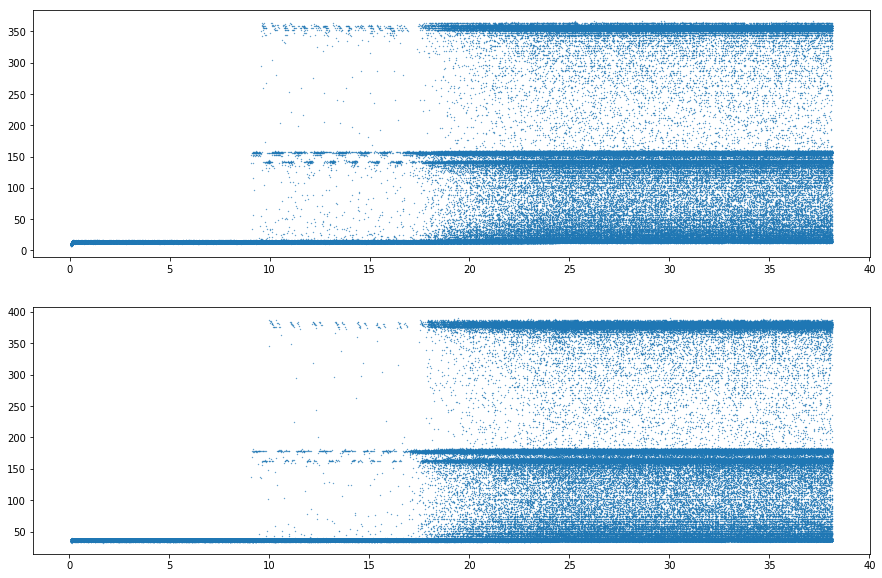

In [129]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.scatter(dfl.Time, dfl.SensorBrightness, s=.1)
ax2.scatter(dfr.Time, dfr.SensorBrightness, s=.1)

In [130]:
df_latency = pd.merge(dfll, dfrl, on='Trial')
df_latency.head()

,Trial,DisplayLatency_x,DisplayLatency_y
0,3,NaN,25.164
1,4,19.300,NaN
2,5,NaN,20.976
3,6,24.512,NaN
4,7,NaN,17.932


**Note**: that when you merge them on trial, then you are missing the first (2) and the last (1001) trials

In [131]:
df_latency.DisplayLatency_x.fillna(df_latency.DisplayLatency_y, inplace=True)
del df_latency['DisplayLatency_y']

In [132]:
df_latency.head()

,Trial,DisplayLatency_x
0,3,25.164
1,4,19.300
2,5,20.976
3,6,24.512
4,7,17.932


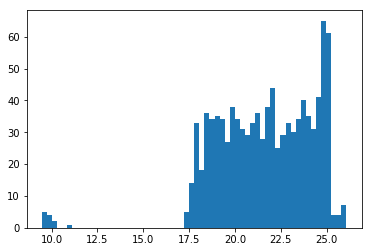

In [133]:
plt.hist(df_latency.DisplayLatency_x, bins=60);

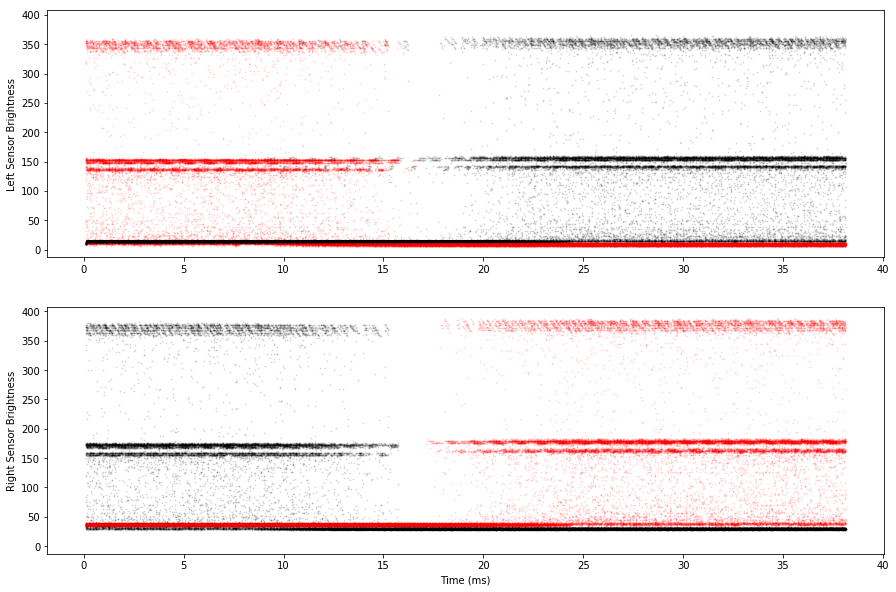

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharey=True)
for name, df in dfd.groupby('Trial'):
    if name < 100:
        color = 'r' if all(df.LED_Position == 'R') else 'k'
        ax1.scatter(df.Time, df.LeftSensorBrightness, s=1, c=color, alpha=.1)
        ax2.scatter(df.Time, df.RightSensorBrightness, s=1, c=color, alpha=.1)
    else:
        break
        
ax1.set(ylabel='Left Sensor Brightness')
ax2.set(xlabel='Time (ms)', ylabel='Right Sensor Brightness');

### Plot the above figure again, but with nice brightness traces

to_left transition

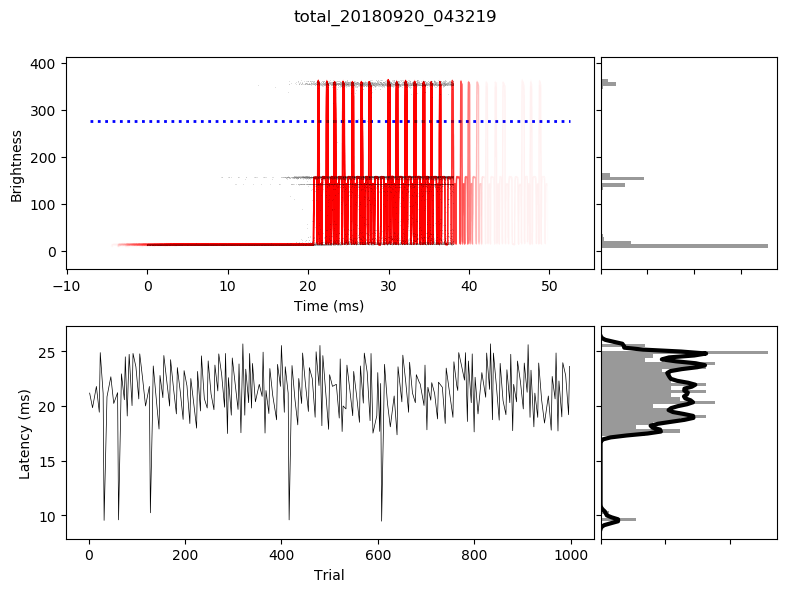

In [139]:
df_transformed = vrl.analysis.add_clusters(dfl)
df_clustered = df_transformed[df_transformed.Cluster == 0].copy()
df_shifted = vrl.analysis.shift_by_sse(df_clustered)
vrl.analysis.plot_display_figures(df_shifted)

to_right transtion

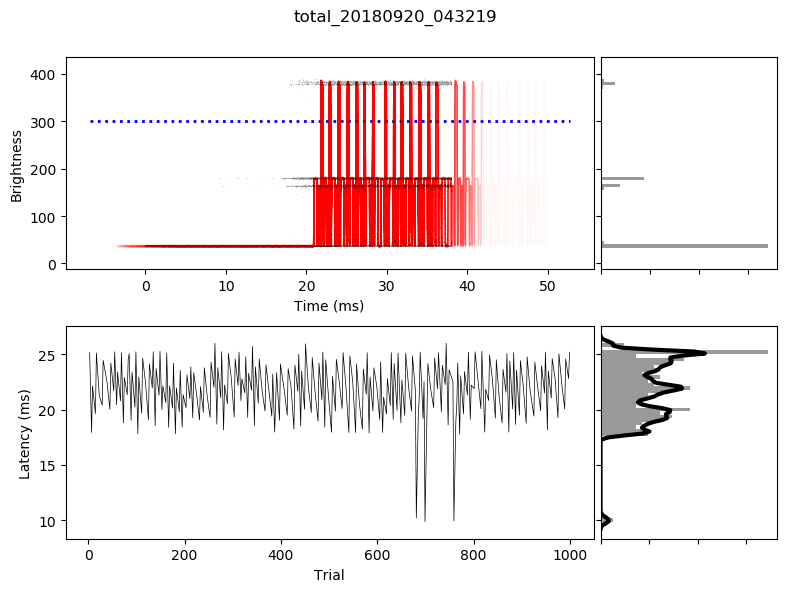

In [140]:
df_transformed = vrl.analysis.add_clusters(dfr)
df_clustered = df_transformed[df_transformed.Cluster == 0].copy()
df_shifted = vrl.analysis.shift_by_sse(df_clustered)
vrl.analysis.plot_display_figures(df_shifted)